In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp


In [2]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


In [7]:
data_path = "/content/drive/MyDrive/archive (1)/samples"

In [9]:
image_fns = os.listdir(data_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1080
[5 9]


In [10]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

2 3mxdn (1).png
3 3fbxd (1).png
5 3n7mx (1).png
7 3n3cf (1).png
10 3eny7 (1).png
17 3n2b4 (1).png
20 3ndxd (1).png
1076 3g2w6 (1).png
1077 3ebnn (1).png
1078 3ebpw (1).png


In [12]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)
print(len(image_fns_train), len(image_fns_test))

810 270


In [13]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

23
[' ', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [14]:

vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

24
['-', ' ', '(', ')', '1', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: ' ', 2: '(', 3: ')', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: 'b', 13: 'c', 14: 'd', 15: 'e', 16: 'f', 17: 'g', 18: 'm', 19: 'n', 20: 'p', 21: 'w', 22: 'x', 23: 'y'}
{'-': 0, ' ': 1, '(': 2, ')': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'm': 18, 'n': 19, 'p': 20, 'w': 21, 'x': 22, 'y': 23}


In [15]:

batch_size = 16

In [16]:
class CAPTCHADataset(Dataset):

    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text

    def transform(self, image):

        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [17]:
trainset = CAPTCHADataset(data_path, image_fns_train)
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader))

51 17


In [21]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('78dw6', '3n2b4 (1)', 'pcpg6', '56m6y', '4fp5g', 'byfgn', 'g78gn', 'mdxpn', 'bpwd7', '8n34n', 'f2fge', 'b4ndb', 'nwg2m', 'gp7c5', 'pg2yx', '3n7mx')


In [22]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

24


In [23]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [24]:
resnet = resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.1MB/s]


In [25]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
class CRNN(nn.Module):

    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):

        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)

        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size,
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size,
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)


    def forward(self, batch):

        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])

        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])

        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])

        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])

        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])

        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])

        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])

        return batch

In [27]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [28]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [29]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('78dw6', '3n2b4 (1)', 'pcpg6', '56m6y', '4fp5g', 'byfgn', 'g78gn', 'mdxpn', 'bpwd7', '8n34n', 'f2fge', 'b4ndb', 'nwg2m', 'gp7c5', 'pg2yx', '3n7mx')
torch.Size([10, 16, 24])


In [30]:

criterion = nn.CTCLoss(blank=0)

In [31]:
def encode_text_batch(text_batch):

    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)

    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)

    return text_batch_targets, text_batch_targets_lens

In [32]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                       fill_value=text_batch_logps.size(0),
                                       dtype=torch.int32).to(device) # [batch_size]
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens)
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [33]:
compute_loss(text_batch, text_batch_logits)


tensor(4.6650, grad_fn=<MeanBackward0>)

In [35]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [37]:

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [38]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [39]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = []
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue

        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:3.0916408090030445    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:2.4448012838176654    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:1.9191021241393744    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:1.6287312788121842    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:1.462795521698746    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:1.338064009068059    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:1.2598869286331476    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:1.1965055465698242    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:1.1697289639828252    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:1.134702811054155    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:1.13827491274067    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:1.074782133102417    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:1.047883411248525    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:1.0220145910393958    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.9577525573618272    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.8911933723618003    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.8617152314560086    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.8544135900104747    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.8854422499151791    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.966071111314437    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.8648616204074785    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.8023002206110487    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.7963328618629306    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.8482310070711023    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.8287536209704829    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.8210709305370555    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.7841405611412198    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.7642733326145247    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.7630844875877979    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.7558378530483619    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.7394053316583821    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.7397293647130331    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.7359461270126642    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.7334616149173063    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.912491943321976    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.857014349862641    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.7864211680842381    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.7335886768266267    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.708309413171282    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.7032125019559673    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.6993528288953444    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.6973183973162782    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.7001666940894782    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.6976179211747413    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.698658942007551    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.7139831839823255    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.7137583131883659    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.8418545652838314    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.7703956272087845    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.6744280749676275    NumUpdates:51


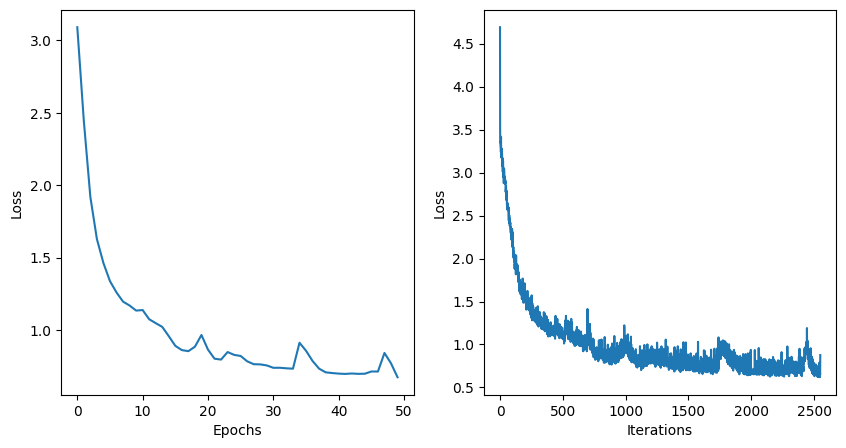

In [40]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [41]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [42]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)


  0%|          | 0/51 [00:00<?, ?it/s]

In [43]:

results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [44]:
print(results_train.shape)
results_train.head()

(810, 2)


,actual,prediction
0,ndecc,nnddeecccc
1,gecmf,ggeeccmmff
2,325fb,332255ffbb
3,6f857,66ff885577
4,87nym,8877nnyymm


In [45]:

print(results_test.shape)
results_test.head()

(270, 2)


,actual,prediction
0,x362g,xx336622gg
1,xemyg,xxeemmyygg
2,mye68,mmyyee6688
3,fbp2c,ffbbpp22cc
4,mggce,mmggggccee


In [46]:

def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [47]:

results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,ndecc,nnddeecccc,ndec
1,gecmf,ggeeccmmff,gecmf
2,325fb,332255ffbb,325fb
3,6f857,66ff885577,6f857
4,87nym,8877nnyymm,87nym


In [48]:

results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,x362g,xx336622gg,x362g
1,xemyg,xxeemmyygg,xemyg
2,mye68,mmyyee6688,mye68
3,fbp2c,ffbbpp22cc,fbp2c
4,mggce,mmggggccee,mgce


In [49]:

mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
4,mggce,mmggggccee,mgce
5,y5dpp,yy55ddpppp,y5dp
6,3nfdn,33nnndddnn,3ndn
9,e2d66,ee22dd6666,e2d6
19,enn7n,eennnn77nn,en7n
20,x44n4,xx4444nn44,x4n4
30,77387,7777788877,787
47,8cccc,88c-----cc,8cc
49,n3ffn,nn33ffffnn,n3fn
53,8bbm4,88bbbbmm44,8bm4


In [50]:

print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
4    39
3     6
5     5
Name: count, dtype: int64


In [51]:

mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
62,cdcb3,eeddccbb33,edcb3
144,3n7mx (1),33nn77mmxx,3n7mx
147,3mxdn (1),33mmxxddnn,3mxdn
164,c353e,cc335533cc,c353c
194,wgnwp,wwggmmwwpp,wgmwp


/content/drive/MyDrive/archive (1)/samples/cdcb3.png


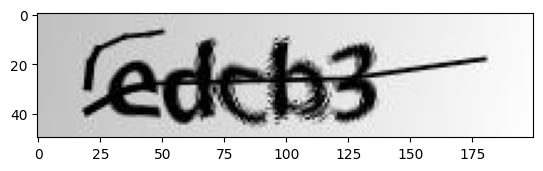

In [52]:

mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [53]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.8580246913580247
0.8148148148148148
